In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


58900480/58889256 [==============================] - 45s 1us/step


In this case we are importing the model VGG16:
- weights: specifies the weight checkpoint from which to initialize the model.
- include_top: refers to including (or not) the densely connected classifier on top of the network.
- input_shape: is the shape of the image tensors that you’ll feed to the network. But this is optional, we can skip this part and the model will adapt to the input we will be using.

In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map will be of size (4,4,512) so this is the one we will be build the classifier on top of. There are two ways we can proceed form this step:

### recording the output of conv_base on your data and using these outputs as inputs to a new model

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/catiafortunato/Deeplearning/Champalimaud/Chapter 5/all_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6027 - acc: 0.6790 - val_loss: 0.4281 - val_acc: 0.8480
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4394 - acc: 0.7970 - val_loss: 0.3459 - val_acc: 0.8710
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3467 - acc: 0.8540 - val_loss: 0.3178 - val_acc: 0.8640
Epoch 4/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3077 - acc: 0.8765 - val_loss: 0.2922 - val_acc: 0.8730
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2752 - acc: 0.8910 - val_loss: 0.2719 - val_acc: 0.8960
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2554 - acc: 0.8995 - val_loss: 0.2695 - val_acc: 0.8830
Epoch 7/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2379 - acc: 0.9000 - val_loss: 0.2566 - val_acc: 0.8980
Epoch 8/30
200

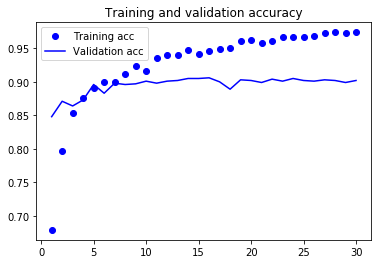

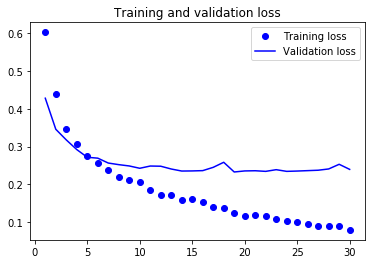

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()